<a href="https://colab.research.google.com/github/mkhi238/NBA-NHL-Player-Comparisions/blob/main/NBA_NHL_Inter_Player_Comps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset
from scipy.spatial.distance import cdist

In [3]:

nhl_df = pd.read_csv('/content/drive/MyDrive/NBA NHL FILES/NHL STATS.csv')
nba_df = pd.read_csv('/content/drive/MyDrive/NBA NHL FILES/NBA STATS.csv', encoding='latin-1')
nba_adv_df = pd.read_csv('/content/drive/MyDrive/NBA NHL FILES/NBA Advanced Stats.csv')
nhl_adv_df = pd.read_csv('/content/drive/MyDrive/NBA NHL FILES/NHL Advanced Stats.csv')
nba_mvp_df = pd.read_csv('/content/drive/MyDrive/NBA NHL FILES/NBA MVPs.csv')
nhl_mvp_df = pd.read_csv('/content/drive/MyDrive/NBA NHL FILES/NHL MVP.csv')
nhl_allstar_df = pd.read_csv('/content/drive/MyDrive/NBA NHL FILES/NHL ALLSTAR.csv')
nba_allstar_df = pd.read_csv('/content/drive/MyDrive/NBA NHL FILES/NBA ALLNBA.csv')

In [4]:
nhl_adv_df.rename(columns = {'name':'Player'}, inplace = True)
nhl_adv_df.set_index('Player', inplace = True)
nhl_adv_df.drop(['position', 'situation', 'BLK'],axis = 1, inplace = True)

In [5]:
nba_adv_df.drop(['Age', 'Team', 'Pos', 'WS', 'WS/48', 'OBPM', 'FTr', 'DBPM'], axis = 1, inplace = True)
nba_adv_df = nba_adv_df.groupby('Player', as_index = False).mean(numeric_only = True)
nba_adv_df.set_index('Player', inplace = True)

In [6]:
nba_adv_df

,PER,TS%,USG%,BPM
Player,,,,
A.J. Green,10.5,0.617,15.2,-2.1
A.J. Lawson,11.2,0.519,20.0,-4.6
AJ Griffin,1.2,0.382,17.3,-9.6
Aaron Gordon,16.8,0.607,17.8,1.3
Aaron Holiday,11.5,0.578,16.7,-1.5
...,...,...,...,...
Zach LaVine,15.1,0.578,23.8,0.1
Zavier Simpson,6.3,0.377,17.5,-5.9
Zeke Nnaji,12.4,0.528,15.4,-3.7


In [7]:
nhl_df = nhl_df[nhl_df['Pos'] != 'G']
nhl_df['AMP'] = pd.to_numeric(nhl_df['ATOI'].str.split(':').str[0], errors='coerce').astype(int)

In [8]:
nhl_df

,Player,Age,Team,Pos,GP,G,A,PTS,+/-,PIM,...,ATOI,FOW,FOL,FO%,BLK,HIT,TAKE,GIVE,-9999,AMP
0,Nikita Kucherov,30,TBL,RW,81,44,100,144,8,22,...,21:40,2,2,50.0,35,45,62,96,kucheni01,21
1,Nathan MacKinnon,28,COL,C,82,51,89,140,35,42,...,22:49,607,707,46.2,69,55,42,82,mackina01,22
2,Connor McDavid,27,EDM,C,76,32,100,132,35,30,...,21:22,442,423,51.1,39,118,68,84,mcdavco01,21
3,Artemi Panarin,32,NYR,LW,82,49,71,120,18,24,...,20:07,1,9,10.0,15,18,34,72,panarar01,20
4,David Pastrňák,27,BOS,RW,82,47,63,110,21,47,...,19:56,8,16,33.3,19,70,54,98,pastrda01,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,Samuel Walker,24,MIN,C,4,0,0,0,-3,0,...,9:22,0,1,0.0,1,2,0,0,walkesa01,9
1162,Colin White,27,2TM,C,28,0,0,0,-5,4,...,9:31,48,77,38.4,12,22,9,9,whiteco02,9
1163,Colin White,27,PIT,C,11,0,0,0,-2,2,...,9:57,12,5,70.6,5,11,5,5,whiteco02,9
1164,Colin White,27,MTL,C,17,0,0,0,-3,2,...,9:15,36,72,33.3,7,11,4,4,whiteco02,9


In [9]:
nhl_adv_df

,GameScore,OnIceGoal%,Corsi %,Shot Attempts,Rebounds,Penalties Taken,FTA
Player,,,,,,,
Ilya Lyubushkin,4.47,0.36,0.38,107,3,22,10
Tommy Novak,52.55,0.59,0.61,240,10,4,14
Colton Sissons,35.27,0.48,0.49,241,18,19,17
Kevin Bahl,11.02,0.46,0.44,166,6,33,8
Fredrik Olofsson,6.49,0.36,0.40,69,5,4,6
...,...,...,...,...,...,...,...
Hampus Lindholm,29.42,0.50,0.48,225,7,24,15
Mikko Rantanen,110.37,0.63,0.61,525,18,24,20
J.T. Compher,30.81,0.44,0.44,186,15,12,16


In [10]:
nhl_df = nhl_df[nhl_df['Pos'] != 'G']
nhl_df = nhl_df.groupby('Player', as_index = False).mean(numeric_only = True)
nhl_df.drop(['FOW', 'FOL', 'PTS', 'EV', 'SH', 'SHG', 'PP', 'PIM', 'TSA', 'FO%', 'GWG', 'SOG', 'HIT'], axis = 1, inplace = True)
nhl_df.set_index('Player', inplace = True)
nhl_df = nhl_df.join(nhl_adv_df)


In [11]:
nba_df = nba_df.groupby('Player', as_index = False).mean(numeric_only = True)
nba_df.drop(['Rk', 'GS', '3P', '3P%', '3PA', '2P', '2PA', '2P%', 'eFG%', 'FT%', 'ORB', 'DRB'], axis = 1, inplace = True)
nba_df.rename(columns = {'G':'GP', 'MP': 'AMP'}, inplace = True)
nba_df.set_index('Player', inplace = True)
nba_df = nba_df.join(nba_adv_df)


In [12]:
nhl_df['MVP'] = nhl_df.index.isin(nhl_mvp_df['Player']).astype(int)
nhl_df['MVP'] = np.log1p(nhl_df['MVP'])
nhl_df['Allstar'] = nhl_df.index.isin(nhl_allstar_df['Player']).astype(int)
nhl_df['Allstar'] = np.log1p(nhl_df['Allstar'])
nhl_df = nhl_df.dropna()
nba_df['Allstar'] = nba_df.index.isin(nba_allstar_df['Player']).astype(int)
nba_df['MVP'] = nba_df.index.isin(nba_mvp_df['Player']).astype(int)
nba_df['MVP'] = np.log1p(nba_df['MVP'])
nba_df['Allstar'] = np.log1p(nba_df['Allstar'])
nba_df = nba_df.dropna()

In [13]:
print(len(nba_df))
print(len(nhl_df))

550
809


In [14]:
print(nba_df.columns, len(nba_df.columns))
print(nhl_df.columns, len(nhl_df.columns))


Index(['Age', 'GP', 'AMP', 'FG', 'FGA', 'FG%', 'FT', 'FTA', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', 'USG%', 'BPM',
       'Allstar', 'MVP'],
      dtype='object') 21
Index(['Age', 'GP', 'G', 'A', '+/-', 'EVG', 'PPG', 'SPCT', 'BLK', 'TAKE',
       'GIVE', 'AMP', 'GameScore', 'OnIceGoal%', 'Corsi %', 'Shot Attempts',
       'Rebounds', 'Penalties Taken', 'FTA', 'MVP', 'Allstar'],
      dtype='object') 21


In [15]:
nhl_df.rename(columns = {'EVG':'FG','PPG':'FT','SPCT':'FG%','GIVE':'TOV','TAKE':'STL','OnIceGoal%':'TS%','Corsi %':'USG%', 'GameScore': 'PER', 'Rebounds':'TRB','Shot Attempts': 'FGA', 'Penalties Taken': 'PF'}, inplace = True)
nba_df.rename(columns = {'BPM':'+/-','PTS':'G','AST':'A'}, inplace = True)
nba_df = nba_df[nba_df['AMP'] >= 5]
nhl_df = nhl_df[nhl_df['AMP'] >= 10]

In [16]:
nhl_df

,Age,GP,G,A,+/-,FG,FT,FG%,BLK,STL,...,AMP,PER,TS%,USG%,FGA,TRB,PF,FTA,MVP,Allstar
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Ekblad,27.0,51.0,4.0,14.0,27.0,3.0,1.0,4.1,59.0,14.0,...,20.0,36.15,0.56,0.55,226.0,9.0,20.0,5.0,0.0,0.000000
Adam Boqvist,23.0,35.0,1.0,9.0,-8.0,1.0,0.0,2.2,42.0,7.0,...,18.0,10.97,0.51,0.54,121.0,5.0,0.0,4.0,0.0,0.000000
Adam Fantilli,19.0,49.0,12.0,15.0,-21.0,11.0,1.0,10.4,25.0,18.0,...,15.0,21.77,0.50,0.54,247.0,20.0,8.0,12.0,0.0,0.000000
Adam Fox,25.0,72.0,17.0,56.0,21.0,10.0,6.0,12.4,123.0,47.0,...,23.0,75.88,0.60,0.59,299.0,11.0,19.0,22.0,0.0,0.693147
Adam Ginning,24.0,9.0,1.0,0.0,0.0,1.0,0.0,16.7,9.0,2.0,...,14.0,3.15,0.50,0.54,15.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach Parise,39.0,30.0,5.0,5.0,-7.0,5.0,0.0,10.0,25.0,11.0,...,12.0,10.23,0.46,0.47,78.0,9.0,4.0,2.0,0.0,0.693147
Zach Werenski,26.0,70.0,11.0,46.0,0.0,9.0,2.0,5.4,130.0,35.0,...,24.0,54.95,0.50,0.52,442.0,20.0,11.0,3.0,0.0,0.000000
Zach Whitecloud,27.0,61.0,2.0,12.0,-3.0,2.0,0.0,3.9,105.0,18.0,...,17.0,13.62,0.47,0.45,141.0,6.0,16.0,14.0,0.0,0.000000


In [17]:
nba_df

,Age,GP,AMP,FG,FGA,FG%,FT,FTA,TRB,A,...,BLK,TOV,PF,G,PER,TS%,USG%,+/-,Allstar,MVP
Player,,,,,,,,,,,,,,,,,,,,,
A.J. Green,24.0,56.0,11.0,1.5,3.5,0.423,0.3,0.3,1.1,0.5,...,0.1,0.2,0.9,4.5,10.5,0.617,15.2,-2.1,0.0,0.0
A.J. Lawson,23.0,42.0,7.4,1.3,2.9,0.446,0.4,0.5,1.2,0.5,...,0.1,0.3,0.5,3.2,11.2,0.519,20.0,-4.6,0.0,0.0
AJ Griffin,20.0,20.0,8.6,0.9,3.1,0.290,0.1,0.1,0.9,0.3,...,0.1,0.4,0.3,2.4,1.2,0.382,17.3,-9.6,0.0,0.0
Aaron Gordon,28.0,73.0,31.5,5.5,9.8,0.556,2.4,3.7,6.5,3.5,...,0.6,1.4,1.9,13.9,16.8,0.607,17.8,1.3,0.0,0.0
Aaron Holiday,27.0,78.0,16.3,2.4,5.3,0.446,0.7,0.8,1.6,1.8,...,0.1,0.7,1.6,6.6,11.5,0.578,16.7,-1.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach LaVine,28.0,25.0,34.9,6.8,15.0,0.452,3.5,4.1,5.2,3.9,...,0.3,2.1,2.3,19.5,15.1,0.578,23.8,0.1,0.0,0.0
Zavier Simpson,26.0,7.0,23.0,2.4,7.7,0.315,0.4,0.6,2.9,3.6,...,0.4,1.4,1.6,6.0,6.3,0.377,17.5,-5.9,0.0,0.0
Zeke Nnaji,23.0,58.0,9.9,1.2,2.6,0.463,0.7,1.1,2.2,0.6,...,0.7,0.5,1.4,3.2,12.4,0.528,15.4,-3.7,0.0,0.0


In [18]:
nhl_df_normalized = (nhl_df - nhl_df.mean()) / nhl_df.std()

In [19]:
nba_df_normalized = (nba_df - nba_df.mean()) / nba_df.std()

In [ ]:
nhl_df_normalized

,Age,GP,G,A,+/-,FG,FT,FG%,BLK,STL,...,AMP,PER,TS%,USG%,FGA,TRB,PF,FTA,MVP,Allstar
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Ekblad,-0.031905,-0.185215,-0.579704,-0.201656,2.141477,-0.632931,-0.309537,-0.668047,0.193540,-0.491754,...,1.167590,0.252453,0.687179,0.685184,0.163673,-0.219352,0.985473,-0.677871,-0.125268,-0.256660
Adam Boqvist,-0.939287,-0.790037,-0.863165,-0.522218,-0.615174,-0.901156,-0.585673,-0.940240,-0.193135,-0.893229,...,0.620655,-0.664684,0.136972,0.550123,-0.573300,-0.667832,-1.361049,-0.797140,-0.125268,-0.256660
Adam Fantilli,-1.846668,-0.260817,0.176195,-0.137543,-1.639073,0.439968,-0.309537,0.234490,-0.579811,-0.262340,...,-0.199748,-0.271313,0.026930,0.550123,0.311068,1.013969,-0.422440,0.157012,-0.125268,-0.256660
Adam Fox,-0.485596,0.608615,0.648631,2.491073,1.668908,0.305856,1.071145,0.521009,1.649260,1.400915,...,1.987993,1.699547,1.127345,1.225428,0.676045,0.004888,0.868147,1.349702,-0.125268,3.890729
Adam Ginning,-0.712441,-1.772875,-0.863165,-1.099232,0.014918,-0.901156,-0.585673,1.137026,-0.943740,-1.179997,...,-0.473216,-0.949513,0.026930,0.550123,-1.317292,-1.228432,-1.361049,-1.274216,-0.125268,-0.256660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach Parise,2.690240,-0.979045,-0.485216,-0.778669,-0.536412,-0.364707,-0.585673,0.177186,-0.579811,-0.663815,...,-1.020151,-0.691637,-0.413236,-0.395306,-0.875108,-0.219352,-0.891744,-1.035678,-0.125268,3.890729
Zach Werenski,-0.258751,0.533013,0.081707,1.849947,0.014918,0.171743,-0.033400,-0.481809,1.808479,0.712672,...,2.261460,0.937209,0.026930,0.280000,1.679732,1.013969,-0.070462,-0.916409,-0.125268,-0.256660
Zach Whitecloud,-0.031905,0.192800,-0.768678,-0.329881,-0.221367,-0.767044,-0.585673,-0.696699,1.239839,-0.262340,...,0.347187,-0.568162,-0.303195,-0.665428,-0.432924,-0.555712,0.516169,0.395550,-0.125268,-0.256660


In [ ]:
nba_df_normalized

,Age,GP,AMP,FG,FGA,FG%,FT,FTA,TRB,A,...,BLK,TOV,PF,G,PER,TS%,USG%,+/-,Allstar,MVP
Player,,,,,,,,,,,,,,,,,,,,,
A.J. Green,-0.416517,0.370254,-1.004620,-0.772220,-0.755298,-0.361140,-0.738168,-0.837932,-1.093108,-0.889942,...,-0.805086,-1.096011,-0.967520,-0.683527,-0.464690,0.697825,-0.516377,-0.142671,-0.309643,-0.12713
A.J. Lawson,-0.650139,-0.207979,-1.403131,-0.856254,-0.879313,-0.113734,-0.666103,-0.718516,-1.049108,-0.889942,...,-0.805086,-0.967182,-1.526299,-0.880441,-0.335109,-0.399217,0.347020,-0.757792,-0.309643,-0.12713
AJ Griffin,-1.351004,-1.116632,-1.270294,-1.024323,-0.837975,-1.791793,-0.882299,-0.957347,-1.181108,-0.998717,...,-0.805086,-0.838353,-1.805688,-1.001619,-2.186260,-1.932839,-0.138641,-1.988035,-0.309643,-0.12713
Aaron Gordon,0.517970,1.072395,1.264678,0.908469,0.546868,1.069513,0.775206,1.192134,1.282899,0.741677,...,0.403808,0.449940,0.429427,0.740314,0.701535,0.585882,-0.048704,0.693895,-0.309643,-0.12713
Aaron Holiday,0.284348,1.278907,-0.417923,-0.394065,-0.383250,-0.113734,-0.449906,-0.539392,-0.873107,-0.182907,...,-0.805086,-0.451865,0.010343,-0.365435,-0.279575,0.261247,-0.246566,0.004959,-0.309643,-0.12713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach LaVine,0.517970,-0.910120,1.641049,1.454692,1.621672,-0.049193,1.567925,1.430966,0.710897,0.959227,...,-0.321529,1.351745,0.988205,1.588560,0.386839,0.261247,1.030542,0.398636,-0.309643,-0.12713
Zavier Simpson,0.050727,-1.653564,0.323750,-0.394065,0.112813,-1.522873,-0.666103,-0.658808,-0.301106,0.796065,...,-0.079750,0.449940,0.010343,-0.456318,-1.242173,-1.988810,-0.102666,-1.077655,-0.309643,-0.12713
Zeke Nnaji,-0.650139,0.452859,-1.126387,-0.898271,-0.941321,0.069132,-0.449906,-0.360269,-0.609107,-0.835555,...,0.645586,-0.709523,-0.269047,-0.880441,-0.112971,-0.298469,-0.480402,-0.536348,-0.309643,-0.12713


In [20]:
col_order = [
    "Age", "GP", "G", "A", "+/-", "FG", "FT", "FG%", "BLK", "STL", "TOV",
    "AMP", "PER", "TS%", "USG%", "FGA", "TRB", "PF", "MVP", "Allstar"
]

nhl_df_normalized = nhl_df_normalized[col_order]
nba_df_normalized = nba_df_normalized[col_order]


In [21]:
full_df = pd.concat([nhl_df_normalized, nba_df_normalized])

In [22]:
full_df

,Age,GP,G,A,+/-,FG,FT,FG%,BLK,STL,TOV,AMP,PER,TS%,USG%,FGA,TRB,PF,MVP,Allstar
Player,,,,,,,,,,,,,,,,,,,,
Aaron Ekblad,-0.031905,-0.185215,-0.579704,-0.201656,2.141477,-0.632931,-0.309537,-0.668047,0.193540,-0.491754,0.126918,1.167590,0.252453,0.687179,0.685184,0.163673,-0.219352,0.985473,-0.125268,-0.256660
Adam Boqvist,-0.939287,-0.790037,-0.863165,-0.522218,-0.615174,-0.901156,-0.585673,-0.940240,-0.193135,-0.893229,-0.429883,0.620655,-0.664684,0.136972,0.550123,-0.573300,-0.667832,-1.361049,-0.125268,-0.256660
Adam Fantilli,-1.846668,-0.260817,0.176195,-0.137543,-1.639073,0.439968,-0.309537,0.234490,-0.579811,-0.262340,-0.485563,-0.199748,-0.271313,0.026930,0.550123,0.311068,1.013969,-0.422440,-0.125268,-0.256660
Adam Fox,-0.485596,0.608615,0.648631,2.491073,1.668908,0.305856,1.071145,0.521009,1.649260,1.400915,0.516679,1.987993,1.699547,1.127345,1.225428,0.676045,0.004888,0.868147,-0.125268,3.890729
Adam Ginning,-0.712441,-1.772875,-0.863165,-1.099232,0.014918,-0.901156,-0.585673,1.137026,-0.943740,-1.179997,-0.986683,-0.473216,-0.949513,0.026930,0.550123,-1.317292,-1.228432,-1.361049,-0.125268,-0.256660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach LaVine,0.517970,-0.910120,1.588560,0.959227,0.398636,1.454692,1.567925,-0.049193,-0.321529,0.431444,1.351745,1.641049,0.386839,0.261247,1.030542,1.621672,0.710897,0.988205,-0.127130,-0.309643
Zavier Simpson,0.050727,-1.653564,-0.456318,0.796065,-1.077655,-0.394065,-0.666103,-1.522873,-0.079750,0.967048,0.449940,0.323750,-1.242173,-1.988810,-0.102666,0.112813,-0.301106,0.010343,-0.127130,-0.309643
Zeke Nnaji,-0.650139,0.452859,-0.880441,-0.835555,-0.536348,-0.898271,-0.449906,0.069132,0.645586,-0.907566,-0.709523,-1.126387,-0.112971,-0.298469,-0.480402,-0.941321,-0.609107,-0.269047,-0.127130,-0.309643


In [23]:
X = torch.tensor(full_df.values, dtype=torch.float32)


In [24]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        encoding_dim = 10

        self.fc1 = nn.Linear(20, 80)
        self.fc2 = nn.Linear(80, 50)
        self.fc3 = nn.Linear(50, 15)
        self.fc4 = nn.Linear(15, encoding_dim)

        self.fc5 = nn.Linear(encoding_dim, 15)
        self.fc6 = nn.Linear(15, 50)
        self.fc7 = nn.Linear(50, 80)
        self.fc8 = nn.Linear(80, 20)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        encoded = self.fc4(x)
        return encoded

    def decode(self, encoded):
        x = F.relu(self.fc5(encoded))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        decoded = self.fc8(x)
        return decoded

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded


In [25]:
def train(model, num_epochs = 10, batch_size = 64):
  torch.manual_seed(1)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0016, weight_decay=8e-7)


  train_loader = DataLoader(TensorDataset(X), batch_size=batch_size, shuffle=True, drop_last = True)
  outputs = []
  epoch_losses = []
  avg_loss = 0.0
  for i in range(num_epochs):
    epoch_loss = 0.0
    for data, in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, data)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_losses.append(avg_loss)
      outputs.append((i, data, output))

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {i} | Loss: {avg_loss:.4f}")
  return outputs, epoch_losses

Epoch 0 | Loss: 0.6144
Epoch 1 | Loss: 0.4556
Epoch 2 | Loss: 0.4010
Epoch 3 | Loss: 0.3603
Epoch 4 | Loss: 0.3393
Epoch 5 | Loss: 0.3035
Epoch 6 | Loss: 0.2834
Epoch 7 | Loss: 0.2734
Epoch 8 | Loss: 0.2529
Epoch 9 | Loss: 0.2390
Epoch 10 | Loss: 0.2313
Epoch 11 | Loss: 0.2180
Epoch 12 | Loss: 0.2086
Epoch 13 | Loss: 0.1999
Epoch 14 | Loss: 0.1978
Epoch 15 | Loss: 0.1935
Epoch 16 | Loss: 0.1925
Epoch 17 | Loss: 0.1884
Epoch 18 | Loss: 0.1909
Epoch 19 | Loss: 0.1858
Epoch 20 | Loss: 0.1808
Epoch 21 | Loss: 0.1794
Epoch 22 | Loss: 0.1762
Epoch 23 | Loss: 0.1810
Epoch 24 | Loss: 0.1726
Epoch 25 | Loss: 0.1716
Epoch 26 | Loss: 0.1562
Epoch 27 | Loss: 0.1514
Epoch 28 | Loss: 0.1514
Epoch 29 | Loss: 0.1745
Epoch 30 | Loss: 0.1447
Epoch 31 | Loss: 0.1422
Epoch 32 | Loss: 0.1366
Epoch 33 | Loss: 0.1397
Epoch 34 | Loss: 0.1446
Epoch 35 | Loss: 0.1352
Epoch 36 | Loss: 0.1316
Epoch 37 | Loss: 0.1306
Epoch 38 | Loss: 0.1275
Epoch 39 | Loss: 0.1265
Epoch 40 | Loss: 0.1247
Epoch 41 | Loss: 0.1228
Ep

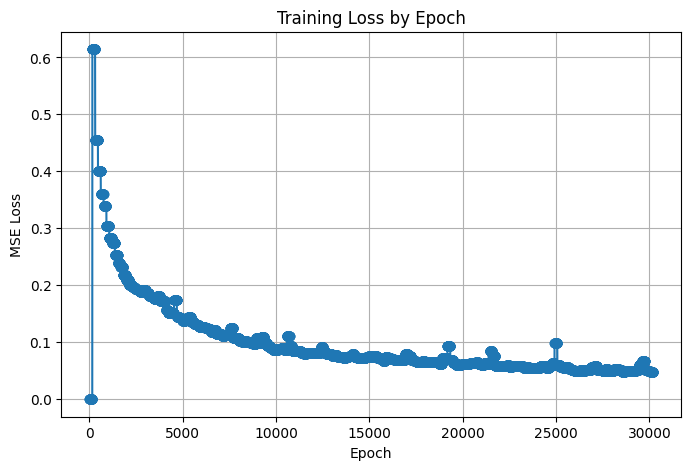

In [26]:
model = Autoencoder()
max_epochs = 200
outputs, epoch_losses = train(model, batch_size = 8, num_epochs=max_epochs)


plt.figure(figsize=(8, 5))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.title("Training Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

In [29]:
nba_players_set = set(nba_df.index)
nhl_players_set = set(nhl_df.index)

In [30]:
with torch.no_grad():
    Z = model.encode(X).numpy()

kmeans = KMeans(n_clusters=5, random_state=1)
clusters = kmeans.fit_predict(Z)


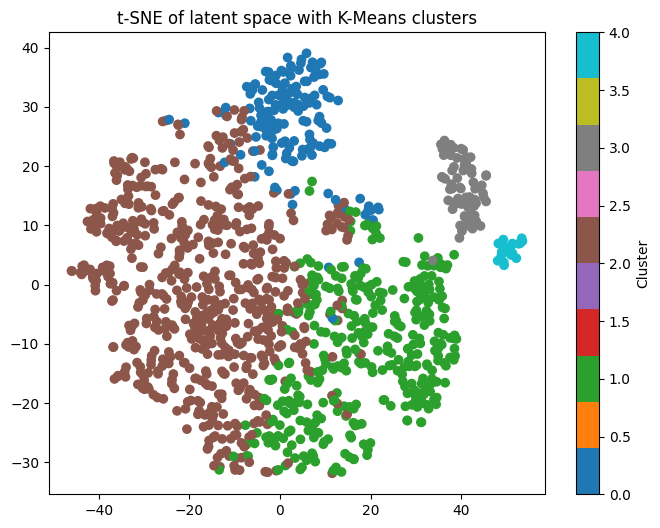

In [31]:

tsne = TSNE(n_components=2, random_state=42)
Z_tsne = tsne.fit_transform(Z)

plt.figure(figsize=(8,6))
plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=clusters, cmap='tab10')
plt.title('t-SNE of latent space with K-Means clusters')
plt.colorbar(label='Cluster')
plt.show()


In [35]:
distances_eucl = cdist(Z, Z, metric='euclidean')
distances_cos = cdist(Z, Z, metric='cosine')

np.fill_diagonal(distances_eucl, 0)
np.fill_diagonal(distances_cos, 0)

pairs = []
for i in range(len(full_df.index)):
    p1 = full_df.index[i]
    in_nba_1 = p1 in nba_players_set
    in_nhl_1 = p1 in nhl_players_set
    for j in range(i + 1, len(full_df.index)):
        p2 = full_df.index[j]
        in_nba_2 = p2 in nba_players_set
        in_nhl_2 = p2 in nhl_players_set
        if (in_nba_1 and in_nhl_2) or (in_nba_2 and in_nhl_1):
            pairs.append((distances_eucl[i, j], distances_cos[i, j], p1, p2))

pairs.sort(key=lambda x: x[0])
print('Euclidian Distance Top 10')
k = 10
for d_eucl, d_cos, p1, p2 in pairs[:k]:
    print(f"NHL player: {p1} ↔ NBA player: {p2} | Euclidean: {d_eucl:.4f} | Cosine: {1 - d_cos:.4f}")


pairs.sort(key=lambda x: x[1])

print('Cosine Similarity Top 10')
k = 10

for d_eucl, d_cos, p1, p2 in pairs[:k]:
    print(f"NHL player: {p1} ↔ NBA player: {p2} | Euclidean: {d_eucl:.4f} | Cosine: {1 - d_cos:.4f}")


Euclidian Distance Top 10
NHL player: Ryan Shea ↔ NBA player: Jamal Cain | Euclidean: 0.6240 | Cosine: 0.9889
NHL player: Ethan Bear ↔ NBA player: Matthew Hurt | Euclidean: 0.7117 | Cosine: 0.9873
NHL player: Jaret Anderson-Dolan ↔ NBA player: D.J. Carton | Euclidean: 0.7167 | Cosine: 0.9819
NHL player: Victor Olofsson ↔ NBA player: Eugene Omoruyi | Euclidean: 0.7857 | Cosine: 0.9327
NHL player: Ty Dellandrea ↔ NBA player: Patrick Baldwin Jr. | Euclidean: 0.7874 | Cosine: 0.9657
NHL player: Jonny Brodzinski ↔ NBA player: Eugene Omoruyi | Euclidean: 0.8153 | Cosine: 0.8767
NHL player: Ryan Shea ↔ NBA player: Troy Brown Jr. | Euclidean: 0.8185 | Cosine: 0.9770
NHL player: Dryden Hunt ↔ NBA player: Jules Bernard | Euclidean: 0.8253 | Cosine: 0.9531
NHL player: Nino Niederreiter ↔ NBA player: Bobby Portis | Euclidean: 0.8263 | Cosine: 0.9652
NHL player: Jack Roslovic ↔ NBA player: Jordan Nwora | Euclidean: 0.8270 | Cosine: 0.9300
Cosine Similarity Top 10
NHL player: Mikael Pyyhtia ↔ NBA pl

In [36]:
pairs.sort(key=lambda x: x[0])

In [37]:
nba_players = full_df.index[full_df.index.isin(nba_players_set)]
nhl_players = full_df.index[full_df.index.isin(nhl_players_set)]
Z_nba = Z[full_df.index.isin(nba_players_set)]
Z_nhl = Z[full_df.index.isin(nhl_players_set)]

In [38]:
def find_closest_nhl_to_nba_player(name, method = 'Squared'):
    mask = (nba_players == name)

    v = Z_nba[mask][0]
    if method == 'Squared':
      sq_dists = np.sum((Z_nhl - v)**2, axis=1)
    if method == 'Abs':
      sq_dists = np.sum(np.abs(Z_nhl - v), axis=1)
    j = np.argmin(sq_dists)
    closest = nhl_players[j]
    dist = float(np.sqrt(sq_dists[j]))

    print(f"Closest NHL player to {name}: {closest} (Distance: {dist:.4f})")
    return closest, dist


In [39]:

#Star-power in the two leauges is really different, so while the comparisions seem apt, the actual distance  between them is far away
#Regardless, the model can find comparisions between star players which make sense in a vaccum (i.e LeBron James to Sidney Crosby)
find_closest_nhl_to_nba_player("LeBron James")
find_closest_nhl_to_nba_player("James Harden")
find_closest_nhl_to_nba_player("Kevin Durant")
find_closest_nhl_to_nba_player("Stephen Curry")
find_closest_nhl_to_nba_player("Giannis Antetokounmpo")
find_closest_nhl_to_nba_player("Kawhi Leonard")
find_closest_nhl_to_nba_player("Ja Morant")
find_closest_nhl_to_nba_player("Shai Gilgeous-Alexander")
find_closest_nhl_to_nba_player("Tyrese Haliburton")




#Role players see some better comparisions (distance wise), perhaps due to the closer distribution of such players
#along an average, meaning that better comparisions can be found easier
find_closest_nhl_to_nba_player("Aaron Gordon")
find_closest_nhl_to_nba_player("Jeff Green")
find_closest_nhl_to_nba_player("Derrick White")
find_closest_nhl_to_nba_player("Luke Kennard")
find_closest_nhl_to_nba_player("Amen Thompson")

Closest NHL player to LeBron James: Nikita Kucherov (Distance: 5.3173)
Closest NHL player to James Harden: Connor McDavid (Distance: 6.0914)
Closest NHL player to Kevin Durant: Sidney Crosby (Distance: 6.3524)
Closest NHL player to Stephen Curry: Patrick Kane (Distance: 6.3644)
Closest NHL player to Giannis Antetokounmpo: Sidney Crosby (Distance: 6.7701)
Closest NHL player to Kawhi Leonard: Cale Makar (Distance: 5.0563)
Closest NHL player to Ja Morant: Mikko Rantanen (Distance: 3.9485)
Closest NHL player to Shai Gilgeous-Alexander: Mikko Rantanen (Distance: 4.0625)
Closest NHL player to Tyrese Haliburton: Mitch Marner (Distance: 2.8051)
Closest NHL player to Aaron Gordon: Phillip Danault (Distance: 1.4554)
Closest NHL player to Jeff Green: Kevin Shattenkirk (Distance: 1.2211)
Closest NHL player to Derrick White: Brady Skjei (Distance: 1.7509)
Closest NHL player to Luke Kennard: Pierre Engvall (Distance: 1.2605)
Closest NHL player to Amen Thompson: Cole Sillinger (Distance: 1.7761)


('Cole Sillinger', 1.7760989665985107)

In [40]:
find_closest_nhl_to_nba_player("Stephen Curry")


Closest NHL player to Stephen Curry: Patrick Kane (Distance: 6.3644)


('Patrick Kane', 6.364409446716309)

In [41]:
find_closest_nhl_to_nba_player("Anthony Davis")


Closest NHL player to Anthony Davis: Roman Josi (Distance: 6.9410)


('Roman Josi', 6.941048622131348)

In [42]:
def find_closest_nba_to_nhl_player(name, method='Squared'):
    mask = (nhl_players == name)

    v = Z_nhl[mask][0]
    if method == 'Squared':
        dists = np.sum((Z_nba - v)**2, axis=1)
    if method == 'Abs':
        dists = np.sum(np.abs(Z_nba - v), axis=1)

    j = np.argmin(dists)
    closest = nba_players[j]
    dist = float(np.sqrt(dists[j])) if method == 'Squared' else float(dists[j])

    print(f"Closest NBA player to {name}: {closest} (Distance: {dist:.4f})")
    return closest, dist


In [43]:

#Star Players have worse (but understandable) predictions
find_closest_nba_to_nhl_player('Connor McDavid')
find_closest_nba_to_nhl_player('Leon Draisaitl')
find_closest_nba_to_nhl_player('Auston Matthews')
find_closest_nba_to_nhl_player('Nikita Kucherov')

#Above average players see closer predictions
find_closest_nba_to_nhl_player('Matthew Tkachuk')
find_closest_nba_to_nhl_player('Adam Fox')



Closest NBA player to Connor McDavid: James Harden (Distance: 6.0914)
Closest NBA player to Leon Draisaitl: Giannis Antetokounmpo (Distance: 8.2587)
Closest NBA player to Auston Matthews: Giannis Antetokounmpo (Distance: 8.5752)
Closest NBA player to Nikita Kucherov: LeBron James (Distance: 5.3173)
Closest NBA player to Matthew Tkachuk: Domantas Sabonis (Distance: 3.4443)
Closest NBA player to Adam Fox: Jalen Williams (Distance: 3.2413)


('Jalen Williams', 3.241328001022339)

In [44]:
X

tensor([[-0.0319, -0.1852, -0.5797,  ...,  0.9855, -0.1253, -0.2567],
        [-0.9393, -0.7900, -0.8632,  ..., -1.3610, -0.1253, -0.2567],
        [-1.8467, -0.2608,  0.1762,  ..., -0.4224, -0.1253, -0.2567],
        ...,
        [-0.6501,  0.4529, -0.8804,  ..., -0.2690, -0.1271, -0.3096],
        [-0.8838,  0.1637, -0.1231,  ...,  0.1500, -0.1271, -0.3096],
        [-0.6501,  0.9485,  2.1036,  ...,  0.9882, -0.1271, -0.3096]])